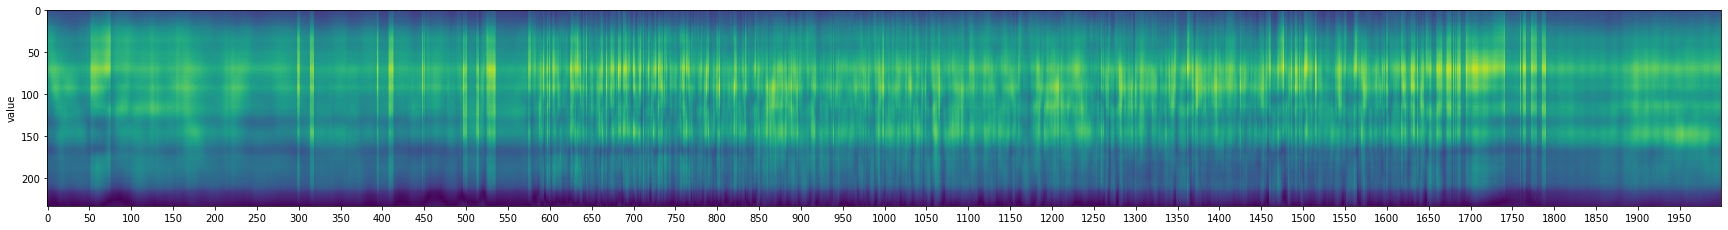

In [124]:

'''
pcap.py
====
Provides fast methods to read bcm4355c0 format
CSI data from .pcap files.
Author: Aravind Reddy V <aravind.reddy@iiitb.org>
License: MIT
'''

__all__ = [
    'read_csi'
]

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

def _read_csi_next(pcapfile, csi_size):
    """
    Note: Designed for internal use only.
    Parameters
    ----------
        pcapfile : File Object
        csi_size : Expected length of CSI in bytes. NFFT * 4
    """

    # Read Frame Size
    pcapfile.seek(8, os.SEEK_CUR)
    frame_size = int.from_bytes(
        pcapfile.read(4),
        byteorder='little',
        signed=False
    )

    # Skip some stuff
    pcapfile.seek(56, os.SEEK_CUR)

    # Read CSI data
    pcapfile.seek(8, os.SEEK_CUR)
    csi = np.frombuffer(
        pcapfile.read(csi_size),
        dtype=np.int16,
        count=int(csi_size / 2)
    )

    # Skip any zero-padding
    pcapfile.seek((frame_size - csi_size - 60), os.SEEK_CUR)

    return csi


def read_csi(pcap_file_path):
    """
    Read CSI data from PCAP file.
    Supports only 40MHz bandwidth,
    and only one Mac ID. You have
    to remove null subcarriers
    yourself.
    Parameters
    ----------
        pcap_file_path : str
    """

    bandwidth = 80

    NFFT = int(bandwidth * 3.2)  # Number of channels in FFT
    chunksize = 1024

    csi = np.zeros((chunksize, NFFT * 2), dtype='int16')

    with open(pcap_file_path, 'rb') as pcapfile:
        filesize = os.stat(pcap_file_path).st_size
        pcapfile.seek(24, os.SEEK_SET)

        npackets = 0
        while pcapfile.tell() < filesize:
            if not (npackets % chunksize):
                csi = np.vstack((csi, np.zeros((chunksize, NFFT * 2), dtype='int16')))

            csi[npackets] = _read_csi_next(pcapfile, NFFT * 4)

            npackets += 1

    # Convert CSI complex numbers to Magnitude.
    csi_converted = np.abs(
        np.fft.fftshift(csi[:npackets, ::2] + 1.j * csi[:npackets, 1::2], axes=(1,))
    )

    return csi_converted

def window(dataFrame, n):
    #window size=n, overleap=(n-1)/2 at each side
    return dataFrame.rolling(n, center=True).mean()

if __name__ == '__main__':
    #csi = pd.DataFrame(read_csi('files/msi_iperf_clnt.pcap'))
    csi = pd.DataFrame(read_csi('raw_csi/betty/exercise20.pcap'))
    #csi2 = pd.DataFrame(read_csi('/content/drive/MyDrive/activity/amber/a_human02.pcap'))
    #csi = pd.concat([csi, csi2], axis=0)
    # 80 MHz
    nullsubcarriers  = np.array([x+128 for x in [-128, -127, -126, -125, -124, -123, -1, 0, 1, 123, 124, 125, 126, 127]])
    pilotsubcarriers = np.array([x+128 for x in [-103, -75, -39, -11, 11, 39, 75, 103]])

    csi = csi.drop(columns=nullsubcarriers)
    csi = csi.drop(columns=pilotsubcarriers)
    indexs = csi.index
    
    # adding windows for smoothing data
    windows = [5, 7, 9]

    #for i in windows:
     # windowed = window(csi, i)
      #csi = pd.concat([csi, windowed], axis=1)
    
    # Deleting rows with NaN values
    csi.dropna(inplace=True)

    # I have not tested this on 80 MHz data yet. It should work, but I can't guarantee it.
    cc = csi.to_numpy()

    plt.figure(figsize=(30, 30))
    plt.imshow(np.transpose(cc))
    plt.ylabel('value')
    plt.xticks(np.arange(min(indexs), max(indexs)+1, 50))
    plt.show()
    normalized = preprocessing.normalize(cc)


In [125]:
#
